# Training Diffusion Model - No vision

[Dataset] Loading Dataset 3d from memory
[3d][@carlo change] Obs: x, x_dot, y, y_dot
[@carlo change] Action: x_acc, y_ acc (?)
Observation Dim:  6 Action Dim:  3
Dimension of the hidden layers:  [256, 512, 1024]
number of parameters: 6.538368e+07


NameError: name 'shrink' is not defined

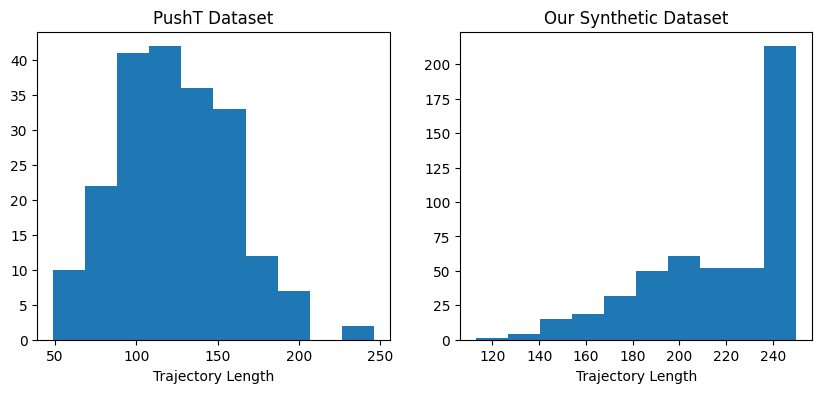

In [1]:
from diffusion_training import training

shrink=1  # how much small the network wrt papers
down_dims=[256//shrink, 512//shrink, 1024//shrink]

training(system_name='3d',
         diffusion_step_embed_dim=256,
         kernel_size=5,
         down_dims=down_dims,
         num_epochs=100,
         num_diffusion_iters=50)


[Dataset] Loading Dataset 2d from memory
[2d][@carlo change] Obs: x, x_dot, y, y_dot
[@carlo change] Action: x_acc, y_ acc (?)
Observation Dim:  4 Action Dim:  2
batch['obs'].shape: torch.Size([256, 2, 4])
batch['action'].shape torch.Size([256, 16, 2])


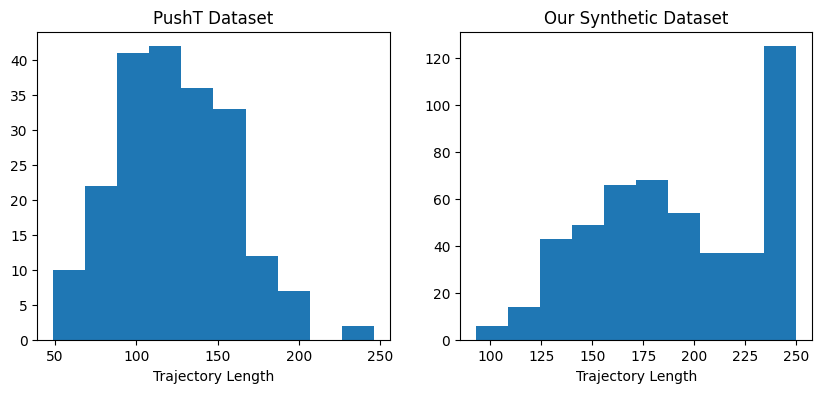

In [1]:
from utils.imports import *

from utils.Dataset import load_dataset, show_statistics
from utils.Components import ConditionalUnet1D
from utils.training import train_loop

system_name = '2d'

# for 2d dataset 8 is ok for 3d 4

# Import synthetic dataset
dataset_ours, obs_dim, action_dim, name, fn_distance, fn_speed = load_dataset(system_name = system_name)  # system can be '2d', '3d', 'drone'
# dataset_ours, obs_dim, action_dim, name, fn_distance, fn_speed  = load_dataset_lqr2d_observation() # to clean,  @carlo

# Show distribution of trajectories length
# same dataset as the paper
show_statistics(dataset_ours=dataset_ours)

# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset_ours,
    batch_size=256,
    num_workers=4,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process after each epoch
    persistent_workers=True
)

# visualize data in batch
batch = next(iter(dataloader))
print("batch['obs'].shape:", batch['obs'].shape)
print("batch['action'].shape", batch['action'].shape)


SHRINK = 1 # how much small the network wrt papers
diffusion_step_embed_dim = 256 # was 256
kernel_size = 5
num_epochs = 100
num_diffusion_iters = 100

TYPE = torch.float32
obs_horizon = dataset_ours.obs_horizon
down_dims = [256//SHRINK, 512//SHRINK, 1024//SHRINK,  ] # 256//SHRINK, 512//SHRINK,
arch = str(down_dims)[1:-1].replace(', ', '_')
print('Dimension of the hidden layers: ', down_dims)

# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon,
    down_dims = down_dims,
    diffusion_step_embed_dim = diffusion_step_embed_dim, # haven't tuned yet, 256
    kernel_size = kernel_size,
)


noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
_ = noise_pred_net.to(device)


# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema = EMAModel(
    model=noise_pred_net,
    power=0.75)

# Standard ADAM optimizer
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(
    params=noise_pred_net.parameters(),
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataloader) * num_epochs
)


# Training Loop
now = datetime.now()  # current date and time
date_time = now.strftime("%m_%d_%H_%M_%S")
num_param = f'{noise_pred_net.num_params:.2e}'.replace('+','').replace('.', '_')

folder = f'pretrained/{system_name}_shr{SHRINK}_{arch}_{num_epochs}_edim{diffusion_step_embed_dim}_ks{kernel_size}_par{num_param}_{date_time}'
train_loop(dataloader,
           noise_pred_net,
           ema,
           optimizer,
           lr_scheduler,
           noise_scheduler,
           num_epochs,
           device,
           system_name,
           folder)
